In [2]:
# Autonomous Driving (Part 1)

In [5]:
#  C:\Users\Admin\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\envs\box2d>

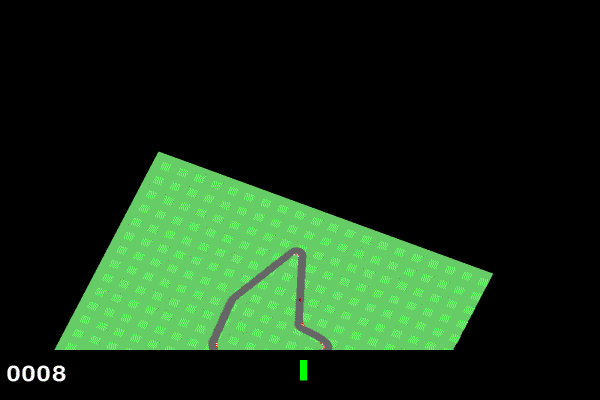

In [6]:
# Instalation of gymnasium libraries

import requests
from IPython.display import Image, display

gif_url = 'https://www.gymlibrary.dev/_images/car_racing.gif'

response = requests.get(gif_url)

# if it worked - you will be able to open this gid

with open('mygif.gif', 'wb') as f:
    f.write(response.content)

display(Image(filename='mygif.gif'))

A car drives a route in a racing environment. The car can turn left, right, accelerate or decelerate. The input is an image with 96x96 pixels. In addition, rewards are given based on the driving behavior. We are not interested in the rewards in this task.
 
*Output*: A training set of at least 5000 images should be generated. You can make of the [car_racing.py](https://github.com/openai/gym/blob/master/gym/envs/box2d/car_racing.py) example from the [Gym examples](https://www.gymlibrary.dev/environments/box2d/car_racing/)  to setup a playing simulator. By playing the in the simulator, you could create 5000 frames and corresponding ground-truth. The ground-truth is simply the control option. The ground-truth can be stored as one-hot vector. The data should include diversity because they will be later used for training a deep neural network.

I included my modification of the car_racing.py in the repository. Generated images and labels are in file: action_shapshots.xlsx

Here, the generated caring car data and the respective ground-truth data will be visualized (e.g. the first 30 images). The visualization should take place after representing the data in PyTorch format. In addition, horizontal and vertical data augmentation are implemented in the data loader. Finally, an additional augmentation for changing the street color from gray to brown is implemented too.


In [2]:
import pandas as pd
df = pd.read_excel(r"C:\Users\Admin\Desktop\fau\second semester\ml lab\assigment 2\Imitation-Learning-Autonomous-Driving-Agent\action_snapshots0.xlsx")


In [3]:
import numpy as np

image_paths = df['Snapshot'].values
labels = df['Action'].apply(eval).values

def transform_label(label):
    if label == [0.0, 0.0, 0.0]:
        return 0
    elif label == [-1.0, 0.0, 0.0]:
        return 1
    elif label == [1.0, 0.0, 0.0]:
        return 2
    elif label == [0.0, 1.0, 0.0]:
        return 3
    elif label == [0.0, 0.0, 0.8]:
        return 4
    elif sum([1 for i in label if i != 0.0]) > 1:
        return 5
    else:
        return 0  # Default to 0 if none of the above conditions match


discrete_labels = np.array([transform_label(label) for label in labels])

for i in range(10):
    print(f"Path: {image_paths[i]}, Label: {discrete_labels[i]}")

Path: test\snapshot_step_0.png, Label: 0
Path: test\snapshot_step_1.png, Label: 0
Path: test\snapshot_step_2.png, Label: 0
Path: test\snapshot_step_3.png, Label: 0
Path: test\snapshot_step_4.png, Label: 0
Path: test\snapshot_step_5.png, Label: 0
Path: test\snapshot_step_6.png, Label: 0
Path: test\snapshot_step_7.png, Label: 0
Path: test\snapshot_step_8.png, Label: 0
Path: test\snapshot_step_9.png, Label: 3


In [12]:
import os 
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# Ensure image paths are strings
image_paths = [str(path) for path in image_paths]

# Convert the paths to absolute paths if necessary
base_path = r'C:\Users\Admin\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\envs\box2d'  # Replace with the base path of your relative paths
image_paths = [os.path.join(base_path, path) for path in image_paths]


# Define a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.brown_color = (115, 70, 31)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            if np.random.rand() > 0.5:
                image = transforms.functional.vflip(image)
                # Swap labels if vertical flip occurs
                if label == 1:
                    label = 2
                elif label == 2:
                    label = 1
            if np.random.rand() > 0.5:
                
                image_np = np.array(image)

                # Define the grey color range.
                lower_grey = np.array([100, 100, 100])
                upper_grey = np.array([200, 200, 200])

                # Create a mask for grey areas.
                mask = np.all(image_np >= lower_grey, axis=-1) & np.all(image_np <= upper_grey, axis=-1)

                # Change grey areas to brown.
                image_np[mask] = self.brown_color

                image = Image.fromarray(image_np)
            image = self.transform(image)

        return image, label
    
# Define the data augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Create the dataset and data loader
dataset = CustomDataset(image_paths=image_paths, labels=discrete_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


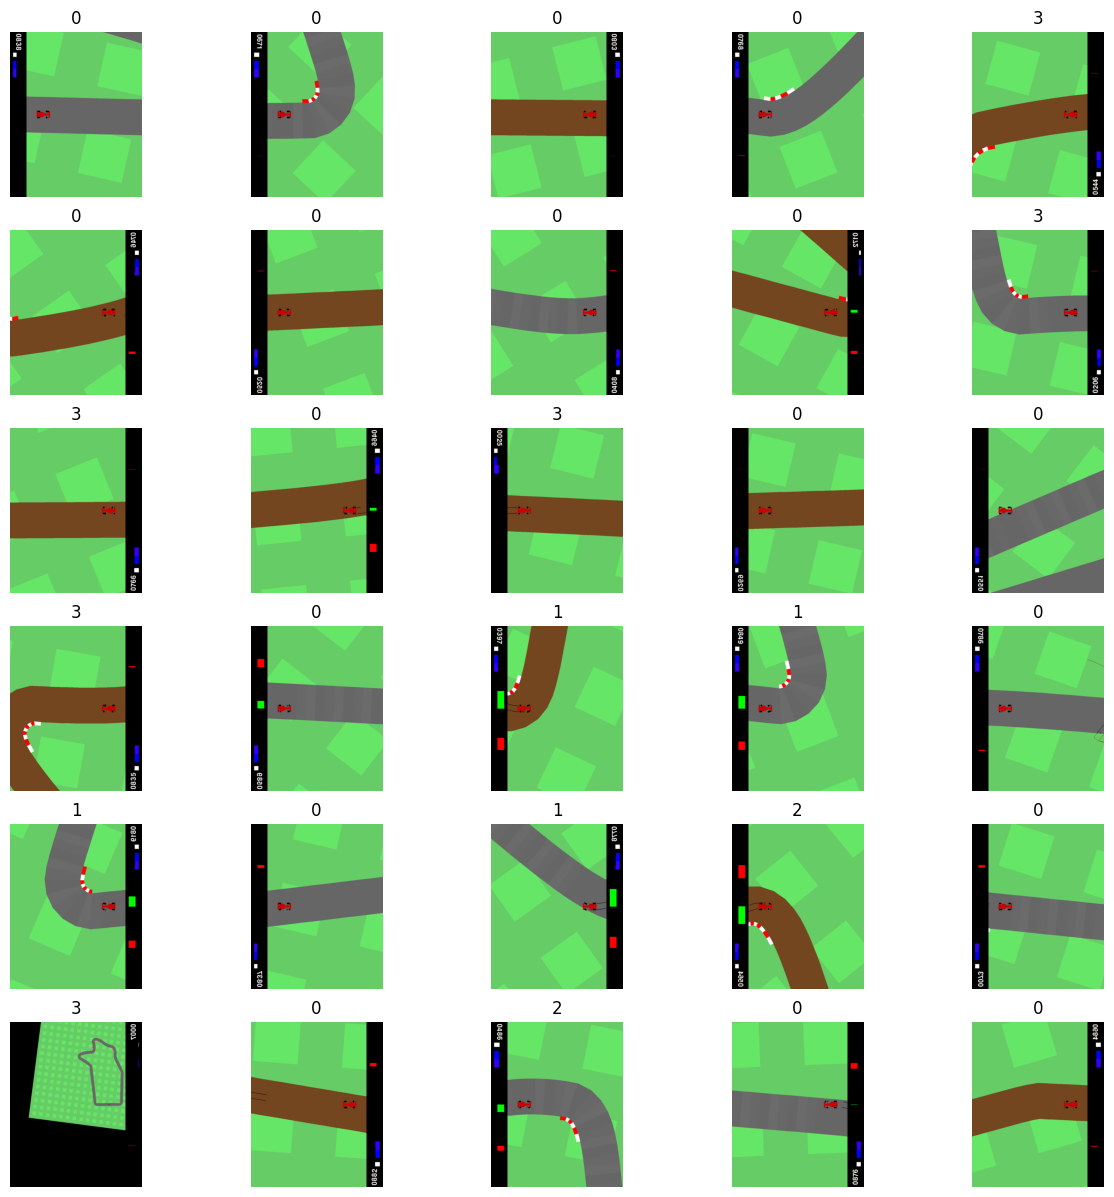

In [13]:
import matplotlib.pyplot as plt


# Function to visualize the first 30 images with labels
def visualize_images(dataloader, num_images=30):
    plt.figure(figsize=(15, 15))
    images_shown = 0
    for images, labels in dataloader:
        for i in range(images.shape[0]):
            if images_shown>= num_images:
                break
            ax = plt.subplot(6,5, images_shown + 1)
            image = images[i].permute(1, 2, 0).numpy()
            plt.imshow(image)
            plt.title(str(labels[i].item()))
            plt.axis("off")
            images_shown += 1
        if images_shown>= num_images:
                break
    plt.show()


# Visualize the first 30 images with their labels
visualize_images(dataloader, num_images=30)